In [2]:
import sys
sys.path.append('/Users/joaoc/Documents/projects/SimulaCorona/.env/lib/python3.7/site-packages')

import pandas as pd
import numpy as np
import plotly.express as px
import yaml
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.dates as md
from tqdm import tqdm

from paths import *
from scripts import get_data, clean_data

%reload_ext autoreload
%autoreload 2

from datetime import datetime
date_time = datetime.today().strftime('%Y-%m-%d-%H-%M')

from scripts.io import to_gbq, read_gbq

In [3]:
def decide_scenario(c2, c3):
    
    if c2 < c3:
        return 'isolation'
    elif c2 >= c3:
        return 'lockdown'
    elif c2 == 0:
        return 'nothing'
    
def update_param(parameters, days, c2, c3):


    for v in config['scenarios'][decide_scenario(c2, c3)]['R0'].values():
        param['R0'] = v
        parameters.append(deepcopy(param))

In [4]:
def load_data():
    
    df_cases_covid19br = get_data.city_cases_covid19br(config['get_data_paths']['cases_covid19br'])
    df_cases_brasilio = get_data.city_cases_brasilio(config['get_data_paths']['cases_brasilio'])

    df_cases_covid19br = clean_data.treat_covid19br(config['raw_paths']['cases_covid19br'], config['treated_paths']['cases_covid19br'])
    df_cases_brasilio = clean_data.treat_brasilio(config['raw_paths']['cases_brasilio'], config['treated_paths']['cases_brasilio']) 

    df_sus = clean_data.treat_sus(config['raw_paths']['sus'], config['treated_paths']['sus'])

    to_gbq(df_cases_brasilio, 'brasilio_cases', if_exists='replace')
    to_gbq(df_sus, 'sus_capacity', if_exists='replace')

    df = pd.merge(df_cases_brasilio, df_sus, how='left', on='region_id')
    
    
    
    return df

In [24]:
def run_model_sequntial(df_city):
    
    final = pd.DataFrame()
    region_id = df_city['region_id'].iloc[0]
    for c2 in config['scenarios']['isolation']['dates']:
        for c3 in config['scenarios']['lockdown']['dates']:
            for bound in ['lower_bound', 'upper_bound']:

                model_params = {k: v[bound] 
                                for k, v in config['model_parameters']['seir'].items()}

                model_params.update(
                    {'days_from_t0': min(c2, c3),
                     'scenario': 'nothing',
                     'R0': config['scenarios']['nothing']['R0'][bound]
                    })

                exposed = (df_city['confirmed_inputed'].values[0] / 1.33 
                                * (1 + 1. / model_params['sick_days'])
                               ) / model_params['sigma']
                current_state = {
                    'population': df_city['populacao'].values[0],
                    'exposed': exposed,
                    'current_infected': df_city['confirmed_inputed'].values[0],
                    'suceptible': df_city['populacao'].values[0] \
                                  - df_city['confirmed_inputed'].values[0] \
                                  - exposed,
                    'recovered': 0
                }

                res = seir.entrypoint(current_state, 
                                     model_params)

                model_params.update(
                    {'days_from_t0': max(c2, c3) - min(c2, c3),
                     'scenario': decide_scenario(c2, c3),
                     'R0': config['scenarios'][decide_scenario(c2, c3)]['R0'][bound]
                    })

                current_state['suceptible'] = res['S'].iloc[-1]
                current_state['exposed'] = res['E'].iloc[-1]
                current_state['current_infected'] = res['I'].iloc[-1]
                current_state['recovered'] = res['R'].iloc[-1]

                res = pd.concat([res, seir.entrypoint(current_state, 
                                                 model_params)[1:]])

                model_params.update(
                        {'days_from_t0': config['estimation_days'] - max(c2, c3),
                         'scenario': decide_scenario(c3, c2),
                         'R0': config['scenarios'][decide_scenario(c3, c2)]['R0'][bound]
                        })

                current_state['suceptible'] = res['S'].iloc[-1]
                current_state['exposed'] = res['E'].iloc[-1]
                current_state['current_infected'] = res['I'].iloc[-1]
                current_state['recovered'] = res['R'].iloc[-1]


                res = pd.concat([res, seir.entrypoint(current_state, 
                                                 model_params)[1:]])


                res = res.reset_index(drop=True).reset_index().drop('days', 1).rename(columns={'index': 'days'})
                res['isolation_t'] = c2
                res['lockdown_t'] = c3
                res['bound'] = bound
                res['region_id'] = region_id
                
                final = pd.concat([final, res])
            
    final = final.pivot_table(index=['region_id', 'isolation_t', 'lockdown_t', 'days'], 
                      columns='bound', 
                      values=['I1', 'I2', 'I3', 'S', 'I', 'R', 'E'])

    final.columns = ['_'.join(col).strip() for col in final.columns.values]
    final = final.reset_index()
    final = final.merge(df[['region_id', 'quantidade_leitos', 'ventiladores_existentes',
                            'city_name', 'state', 'sus_region_name']], on='region_id')
    
#     to_gbq(final, 'model_evolution', if_exists='append',
# #       progress_bar=False
#       )
    
    final.to_csv(TREAT_PATH / 'cities' / (region_id + '.csv'), index=False)


In [6]:
def pivot_to(_df, key):
    a = _df.pivot_table(index='variation_perc', columns='resource', values=key, dropna=False)
    return a.rename(columns={c: key + '_' + c for c in a.columns})



def get_limits(_df):
    
    d = []
    for arg in config['resources']:
        for variation_perc in arg['variation_perc']:
            for bound in ['lower', 'upper']:
                
                var = variation_perc / 100
                n_resource = int(_df[arg['resource']].iloc[0] * var)
                
                day = _df[n_resource < _df[f'{arg["infected"]}_{bound}_bound']].head(1)

                if len(day):
                    dday = day['days'].values[0]
                else:
                    dday = np.nan
                    
                res = {}    
                res['resource'] = f'{arg["resource"]}_{bound}'
                res['dday'] =  dday
                res['variation_perc'] = variation_perc
                res['number'] = n_resource
                
                d.append(res)
    d = pd.DataFrame(d)
    return pd.concat([pivot_to(d, 'dday'), pivot_to(d, 'number')], 1)

In [7]:
from models import seir

In [8]:
config = yaml.load(open('../configs/config.yaml', 'r'), Loader=yaml.FullLoader)


In [9]:
df = load_data()

1it [01:06, 66.25s/it]


KeyboardInterrupt: 

In [10]:
df = read_gbq('select * from `robusta-lab.simula_corona.cities_cases`')

Downloading: 100%|██████████| 5498/5498 [00:01<00:00, 2848.61rows/s]


In [ ]:
, "RJ", "SP", "BA", "SC"

In [29]:
from multiprocessing.pool import Pool
from functools import partial
import time

n_processes = 5

# Fixed Extra Variable
times = [df.query(f"region_id == '{region_id}'")
         for region_id in 
         df.query('state in ("SE")')['region_id'].unique()]

with Pool(n_processes) as p:
    p.map(run_model_sequntial, times)
    


In [45]:
ids = [region_id
         for region_id in 
         df.query('state in ("BA")')['region_id'].unique()
        ]

In [53]:
ids = [ids[3]]

In [54]:
break_list_in_chuncks = lambda data, chunck: [data[x:x+chunck] for x in range(0, len(data), chunck)]

In [55]:
for ch in break_list_in_chuncks(ids, 50):
    
    f = pd.concat([pd.read_csv(TREAT_PATH / 'cities' / (region_id + '.csv'))
                     for region_id in ch ])
    to_gbq(f, 'model_evolution', if_exists='append')


0it [00:00, ?it/s]
1it [00:15, 15.26s/it]


In [56]:
final = pd.concat([pd.read_csv(TREAT_PATH / 'cities' / (region_id + '.csv'))
                     for region_id in ids ])

In [57]:
dday = final.groupby(['region_id', 'isolation_t', 'lockdown_t'])\
        .apply(get_limits).reset_index()

In [58]:
dday = dday.merge(df[['region_id', 'city_name', 'state', 'sus_region_name']], 
                  on='region_id')

In [59]:
best_case = dday.query('lockdown_t == 1')\
            .query('isolation_t == 60')\
            .query('variation_perc == 20')\
            .drop(['lockdown_t', 'isolation_t'], 1)
worst_case = dday.query('lockdown_t == 60')\
            .query('isolation_t == 60')\
            .query('variation_perc == 20').drop(['lockdown_t', 'isolation_t'], 1)

In [60]:
to_gbq(best_case, 'best_case', if_exists='append')
to_gbq(worst_case, 'worst_case', if_exists='append')


1it [00:03,  3.33s/it]

1it [00:03,  3.85s/it]


In [ ]:
keep = ['region_id', 'isolation_t', 'lockdown_t', 'variation_perc',  'city_name', 'state', 'sus_region_name']
for r in config['resources']:
    temp = dday[keep + [c for c in dday.columns if r['resource'] in c]]
    temp = temp.rename(columns={'variation_perc': f'variation_perc_{r["resource"]}'})
    to_gbq(temp,
           f'dday_{r["resource"]}_filter', if_exists='append')


In [121]:
final.columns

Index(['region_id', 'isolation_t', 'lockdown_t', 'days', 'E_lower_bound',
       'E_upper_bound', 'I_lower_bound', 'I_upper_bound', 'I1_lower_bound',
       'I1_upper_bound', 'I2_lower_bound', 'I2_upper_bound', 'I3_lower_bound',
       'I3_upper_bound', 'R_lower_bound', 'R_upper_bound', 'S_lower_bound',
       'S_upper_bound', 'quantidade_leitos', 'ventiladores_existentes',
       'city_name', 'state', 'sus_region_name'],
      dtype='object')

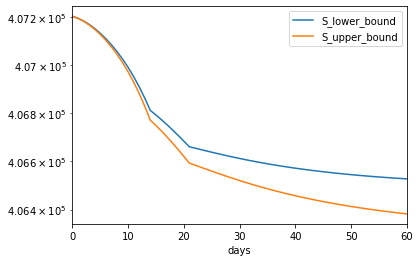

In [158]:
final.query('region_id == "AC RIO BRANCO"')\
.query('isolation_t == 14').query('lockdown_t == 21').set_index('days')\
[['S_lower_bound', 'S_upper_bound']].plot(logy=True)

In [84]:
(15 - 10 + 1. / 15 * 10) / 0.2 

28.333333333333332

In [83]:
(15 - 10 * (1 + 1./15)) / 0.2

21.666666666666668

In [ ]:
(I1 - I0 + gamma * I0) / sigma

In [99]:
I1 = 13
I0 = 10
gamma = 1./15
sigma = 0.2

In [100]:
(I1 - I0 * (1 + gamma)) / sigma

11.66666666666667

In [103]:
(I1 - gamma) * I0 / sigma 

646.6666666666666

In [ ]:
I1 - I0 = sigma * E0 - gamma * I0

In [ ]:
( I1 - I0 + I0 * gamma) / sigma
( I1 - I0 (1  + gamma) ) / sigma

In [ ]:
(I1 - I0 (1 + gamma)) / sigma

In [ ]:
E0 = (I0 / sigma) * (I1 + gamma) 

In [ ]:
I1 / I0 ~ 1.33

In [ ]:
I1 / 1.33 = I0 

In [95]:
I0 = I1 / 1.33

In [96]:
I0

11.278195488721805

In [101]:
(I1 - I0 * (1 + gamma)) / sigma

11.66666666666667